In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
#importing the image data into the tf dataset pipeline

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle="True",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names

In [6]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)


68

In [8]:
68*32

2176

In [9]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[173. 176. 193.]
  [166. 169. 186.]
  [168. 171. 188.]
  ...
  [195. 197. 210.]
  [172. 174. 187.]
  [ 70.  72.  85.]]

 [[166. 169. 186.]
  [166. 169. 186.]
  [169. 172. 189.]
  ...
  [156. 158. 171.]
  [145. 147. 160.]
  [182. 184. 197.]]

 [[164. 167. 184.]
  [171. 174. 191.]
  [174. 177. 194.]
  ...
  [143. 145. 158.]
  [163. 165. 178.]
  [120. 122. 135.]]

 ...

 [[180. 182. 194.]
  [175. 177. 189.]
  [172. 174. 186.]
  ...
  [187. 184. 195.]
  [106. 103. 114.]
  [152. 149. 160.]]

 [[176. 178. 190.]
  [168. 170. 182.]
  [165. 167. 179.]
  ...
  [109. 106. 117.]
  [147. 144. 155.]
  [152. 149. 160.]]

 [[167. 169. 181.]
  [159. 161. 173.]
  [157. 159. 171.]
  ...
  [146. 143. 154.]
  [136. 133. 144.]
  [ 98.  95. 106.]]]


In [10]:
#DATA VISUALISATION USING MATPLOTLIB.PYPLOT

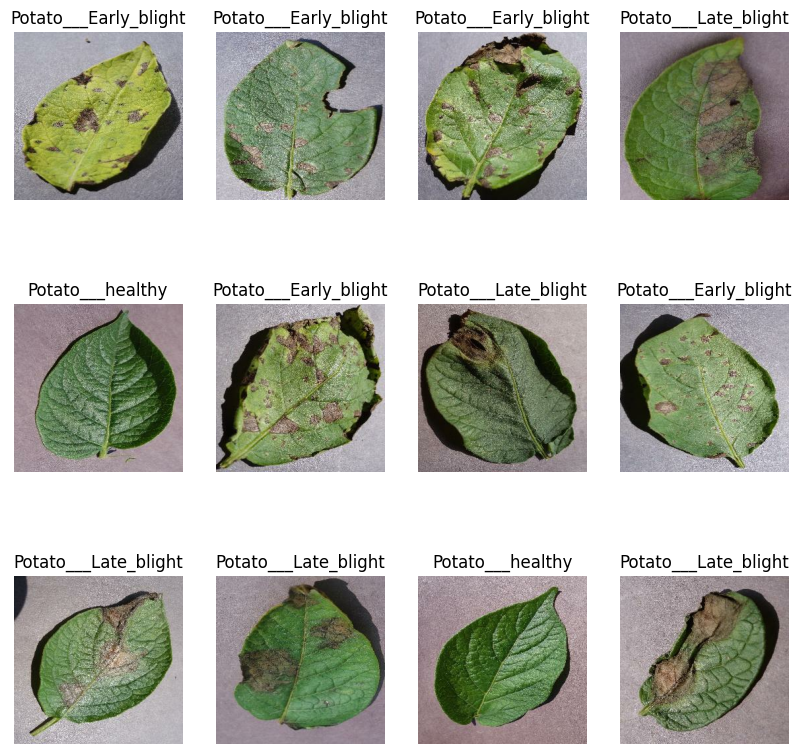

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

we will set 80% data for the training purposes
20% for the test section
where 10% validation 10% test10%

In [12]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds=dataset.take(54)
len(train_ds)

54

In [14]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds=test_ds.skip(6)

In [18]:
len(test_ds)

8

In [19]:
# doing this with the help of a function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [21]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [24]:
#doing the data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
#Applying the data Augmentaion
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
#compile using the adam optimmzers and others as well 
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 118s 2s/step - loss: 0.9277 - accuracy: 0.4695 - val_loss: 0.8789 - val_accuracy: 0.6979
Epoch 2/50
54/54 [==============================] - 140s 3s/step - loss: 0.8036 - accuracy: 0.5681 - val_loss: 0.6512 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 123s 2s/step - loss: 0.5115 - accuracy: 0.7723 - val_loss: 0.3693 - val_accuracy: 0.8906
Epoch 4/50
54/54 [==============================] - 125s 2s/step - loss: 0.4286 - accuracy: 0.8234 - val_loss: 0.4135 - val_accuracy: 0.8021
Epoch 5/50
54/54 [==============================] - 132s 2s/step - loss: 0.3235 - accuracy: 0.8703 - val_loss: 0.3165 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 140s 3s/step - loss: 0.2911 - accuracy: 0.8873 - val_loss: 0.2590 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 120s 2s/step - loss: 0.2588 - accuracy: 0.8967 - val_loss: 0.1955 - val_accuracy: 0.9115
Epoch 8/50
54

In [32]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 417ms/step - loss: 0.0803 - accuracy: 0.9688


In [33]:
scores

[0.08029720932245255, 0.96875]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

50

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.927721381187439,
 0.8035860657691956,
 0.5114779472351074,
 0.4286443591117859,
 0.32352399826049805]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

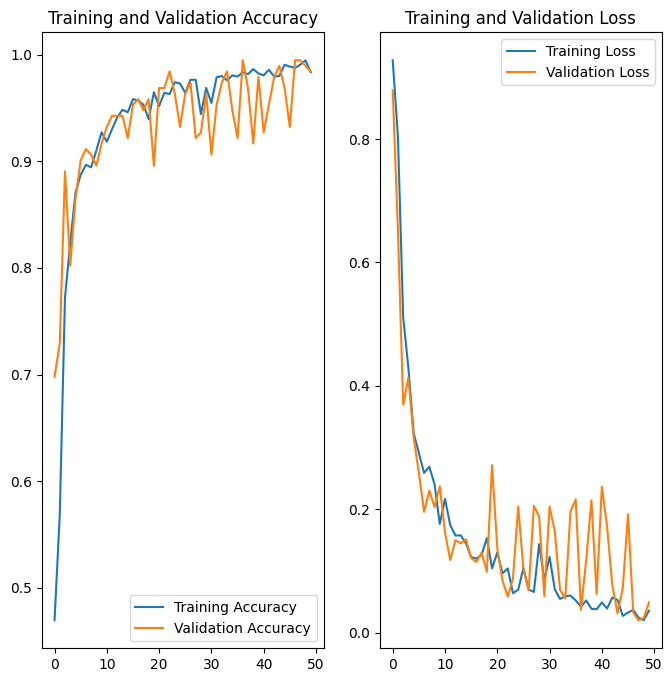

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 680ms/step
predicted label: Potato___Early_blight


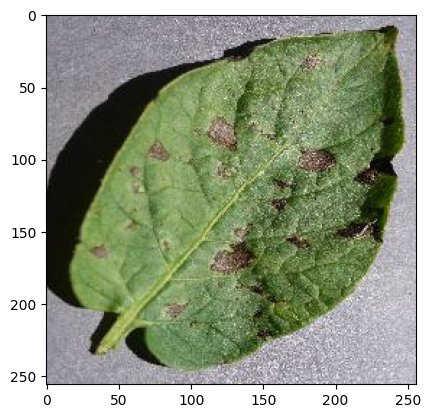

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


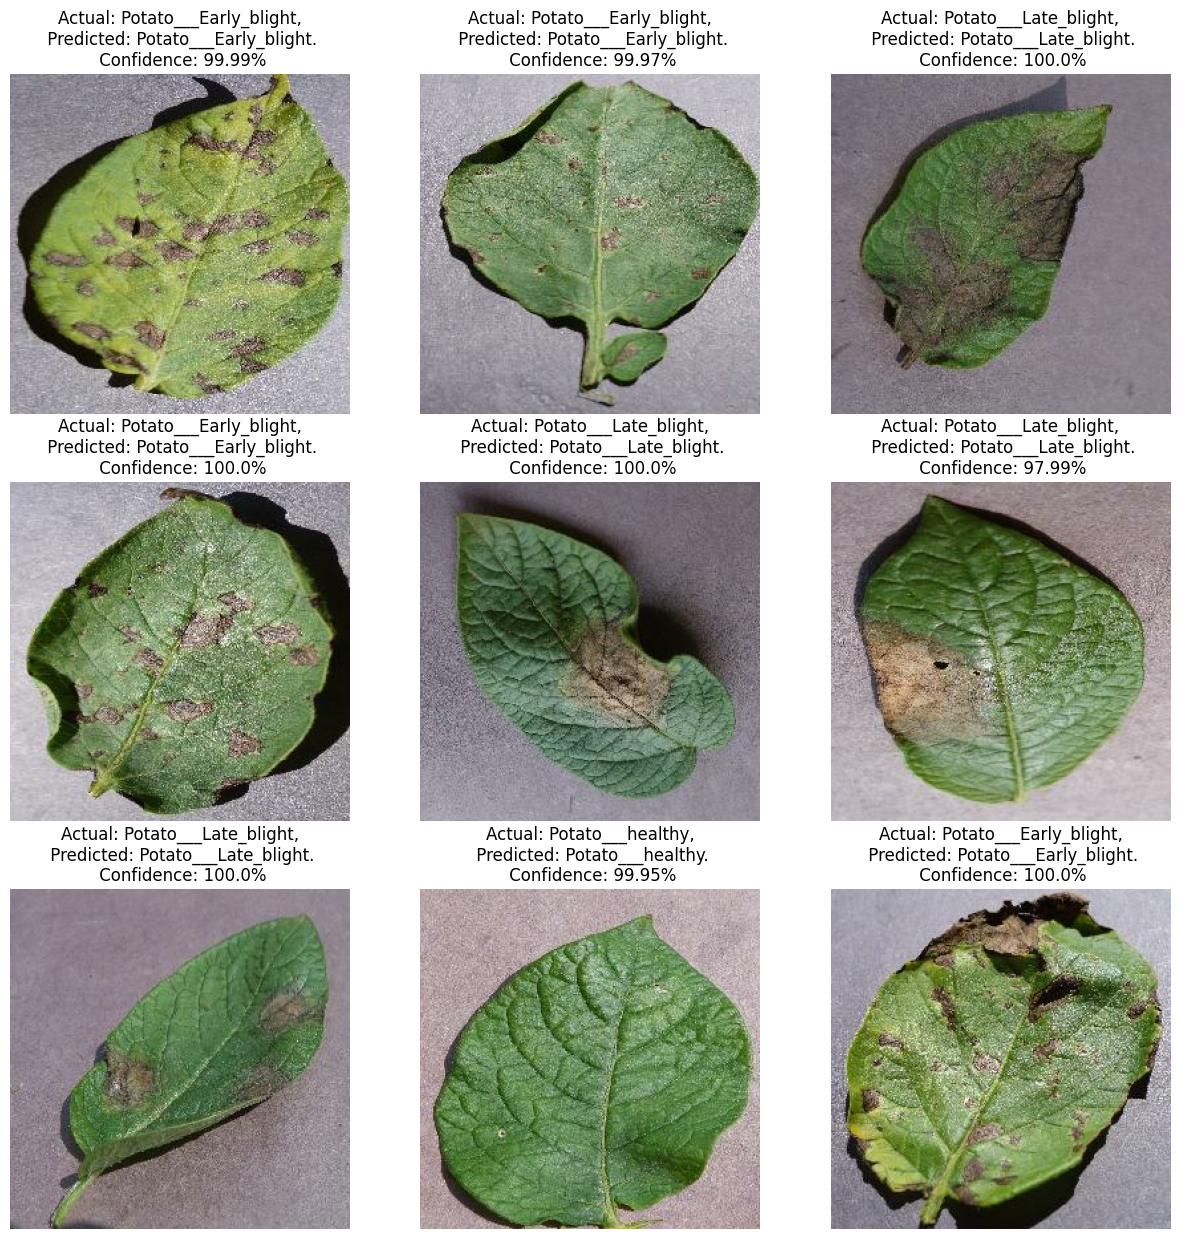

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [45]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [46]:
model.save("../potatoes.h5")